In [1]:
## importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Set seaborn style for aesthetically pleasing plots
sns.set_style("whitegrid")
sns.set_palette("husl")

# Display plots inline in Jupyter
%matplotlib inline

# importing data

data = pd.read_csv('data_cleaned.csv')
print("Data imported successfully")

Data imported successfully


In [2]:
### Descriptive statistics 

def calculate_region_statistics(df, return_format='dataframe'):
    """
    Calculate descriptive statistics for total_investment variable for each region.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: 'region', 'year', 'total_investment'
    return_format : str, optional
        Format of the output. Options: 'dataframe', 'dict'.
        Default is 'dataframe'.
    
    Returns:
    --------
    pandas.DataFrame or dict
        If return_format='dataframe': Returns a DataFrame with statistics for each region.
        If return_format='dict': Returns a dictionary with region names as keys.
    """
    
    # Group by region and calculate descriptive statistics
    # This calculates stats SEPARATELY for each region (one row per region)
    stats = df.groupby('region')['total_investment'].agg([
        ('count', 'count'),
        ('mean', 'mean'),
        ('median', 'median'),
        ('std', 'std'),
        ('min', 'min'),
        ('max', 'max'),
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75)),
        ('range', lambda x: x.max() - x.min())
    ]).round(2)
    
    # Sort by mean investment (highest to lowest)
    stats = stats.sort_values('mean', ascending=False)
    
    # Rename columns for clarity
    stats.columns = [
        'Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', 
        '25th Percentile', '75th Percentile', 'Range'
    ]
    
    if return_format == 'dict':
        return stats.to_dict('index')
    else:
        # Format the statistics for better readability (as a display copy)
        stats_display = stats.copy()
        # Convert numeric columns to formatted strings for display
        for col in ['Mean', 'Median', 'Std Dev', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Range']:
            stats_display[col] = stats[col].apply(lambda x: f'£{x/1e6:.2f}M')
        return stats_display

print("Function 'calculate_region_statistics' created successfully!")
print("\nUsage example:")
print("  stats = calculate_region_statistics(data)")
print("  print(stats)")


Function 'calculate_region_statistics' created successfully!

Usage example:
  stats = calculate_region_statistics(data)
  print(stats)


In [3]:
## Example: Calculate descriptive statistics for each region

# Calculate statistics (this calculates stats PER REGION, not for the entire dataset)
stats = calculate_region_statistics(data)

# Display the results
print("Descriptive Statistics for Total Investment - PER REGION:")
print("="*80)
print(stats)
print("\n" + "="*80)
print("Note: Each row shows statistics for that specific region only.")
print("The function uses groupby('region') to calculate stats separately for each region.\n")

# Verify: Show that each region has its own statistics
print("Verification - Sample data for one region (London):")
london_data = data[data['region'] == 'London']['total_investment']
print(f"London - Count: {len(london_data)}, Mean: £{london_data.mean()/1e6:.2f}M")
print(f"London - Min: £{london_data.min()/1e6:.2f}M, Max: £{london_data.max()/1e6:.2f}M")
print("\nCompare with the stats table above to confirm they match!")


Descriptive Statistics for Total Investment - PER REGION:
                      Count      Mean    Median   Std Dev      Min       Max  \
region                                                                         
Northern Ireland         26  £296.37M  £305.81M  £125.48M  £22.62M  £469.26M   
Yorkshire and Humber     26  £290.70M  £302.94M  £144.56M  £59.30M  £493.99M   
South East               26  £282.05M  £270.29M  £137.72M  £42.42M  £492.35M   
West Midlands            26  £276.01M  £283.21M  £135.97M  £20.92M  £490.73M   
North East               26  £275.62M  £300.17M  £136.05M  £10.10M  £464.65M   
Scotland                 26  £268.10M  £256.03M  £134.79M  £22.60M  £493.76M   
South West               26  £259.53M  £268.86M  £161.61M  £19.38M  £496.37M   
North West               26  £251.77M  £255.74M  £121.60M  £19.40M  £472.40M   
London                   26  £226.44M  £223.04M  £150.79M  £15.82M  £486.62M   
East                     26  £211.28M  £224.45M  £138.28M  £19

In [4]:
## Function to calculate Coefficient of Variation (CV) for each region

def calculate_coefficient_of_variation(df, sort_by_cv=True):
    """
    Calculate the Coefficient of Variation (CV = std dev / mean) for total_investment 
    for each region. CV measures relative volatility/variability.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: 'region', 'year', 'total_investment'
    sort_by_cv : bool, optional
        If True, sort results by CV value (highest to lowest).
        Default is True.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns: 'Region', 'Mean', 'Std Dev', 'CV', 'CV_Interpretation'
        - CV: Coefficient of Variation (std/mean)
        - CV_Interpretation: Text description of volatility level
    """
    
    # Group by region and calculate mean and std dev
    cv_stats = df.groupby('region')['total_investment'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)
    
    # Calculate Coefficient of Variation (CV = std / mean)
    cv_stats['CV'] = (cv_stats['std'] / cv_stats['mean']).round(4)
    
    # Interpret CV values using rule of thumb:
    # CV < 10% (0.10): Very low variation; data is highly consistent and stable
    # CV 10%-20% (0.10-0.20): Moderate variation; acceptable in most practical applications
    # CV > 20% (0.20): High variation; indicates less stable or unpredictable data
    def interpret_cv(cv_value):
        if cv_value < 0.10:
            return 'Very low variation'
        elif cv_value < 0.20:
            return 'Moderate variation'
        else:
            return 'High variation'
    
    cv_stats['CV_Interpretation'] = cv_stats['CV'].apply(interpret_cv)
    
    # Sort by CV if requested (highest to lowest)
    if sort_by_cv:
        cv_stats = cv_stats.sort_values('CV', ascending=False)
    
    # Rename columns for clarity
    cv_stats.columns = ['Mean', 'Std Dev', 'CV', 'CV_Interpretation']
    cv_stats.index.name = 'Region'
    
    # Format Mean and Std Dev for display
    cv_display = cv_stats.copy()
    cv_display['Mean'] = cv_stats['Mean'].apply(lambda x: f'£{x/1e6:.2f}M')
    cv_display['Std Dev'] = cv_stats['Std Dev'].apply(lambda x: f'£{x/1e6:.2f}M')
    # Format CV as both decimal and percentage for clarity
    cv_display['CV'] = cv_stats['CV'].apply(lambda x: f'{x:.4f} ({x*100:.2f}%)')
    
    return cv_display

print("Function 'calculate_coefficient_of_variation' created successfully!")
print("\nUsage example:")
print("  cv_results = calculate_coefficient_of_variation(data)")
print("  print(cv_results)")
print("\nNote: CV measures relative volatility. Higher CV = more volatile investment patterns.")


Function 'calculate_coefficient_of_variation' created successfully!

Usage example:
  cv_results = calculate_coefficient_of_variation(data)
  print(cv_results)

Note: CV measures relative volatility. Higher CV = more volatile investment patterns.


In [5]:
## Example: Calculate Coefficient of Variation for each region

# Calculate CV for each region (sorted by CV, highest to lowest)
cv_results = calculate_coefficient_of_variation(data, sort_by_cv=True)

# Display the results
print("Coefficient of Variation (CV) by Region - Volatility Analysis:")
print("="*80)
print("CV = Standard Deviation / Mean")
print("Higher CV indicates more volatile investment patterns over time.\n")
print(cv_results)
print("\n" + "="*80)
print("Interpretation Guide (Rule of Thumb):")
print("  - CV < 10% (0.10): Very low variation; data is highly consistent and stable")
print("  - CV 10%-20% (0.10-0.20): Moderate variation; acceptable in most practical applications")
print("  - CV > 20% (0.20): High variation; indicates less stable or unpredictable data")
print("                     (may signal need for further investigation)")
print("\nRegions at the top have the most volatile investment patterns.")
print("Regions at the bottom have the most stable investment patterns.")


Coefficient of Variation (CV) by Region - Volatility Analysis:
CV = Standard Deviation / Mean
Higher CV indicates more volatile investment patterns over time.

                          Mean   Std Dev               CV CV_Interpretation
Region                                                                     
East Midlands         £195.68M  £138.56M  0.7081 (70.81%)    High variation
London                £226.44M  £150.79M  0.6659 (66.59%)    High variation
East                  £211.28M  £138.28M  0.6545 (65.45%)    High variation
South West            £259.53M  £161.61M  0.6227 (62.27%)    High variation
Scotland              £268.10M  £134.79M  0.5028 (50.28%)    High variation
Yorkshire and Humber  £290.70M  £144.56M  0.4973 (49.73%)    High variation
North East            £275.62M  £136.05M  0.4936 (49.36%)    High variation
West Midlands         £276.01M  £135.97M  0.4926 (49.26%)    High variation
South East            £282.05M  £137.72M  0.4883 (48.83%)    High variation
Nort

In [6]:
## Function to calculate average year-over-year (YoY) growth in investment per region

def calculate_average_annual_increase(df, return_format='absolute', region_order=None):
    """
    Calculate the average year-over-year (YoY) growth in investment for each region.
    This calculates the average of all year-over-year changes, not a baseline comparison.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: 'region', 'year', 'total_investment'
    return_format : str, optional
        Format of the increase. Options: 'absolute', 'percentage', 'both'.
        - 'absolute': Returns average absolute YoY change in £
        - 'percentage': Returns average YoY percentage change
        - 'both': Returns both absolute and percentage
        Default is 'absolute'.
    region_order : list, optional
        Custom list of region names in the desired order.
        If provided, results will be ordered according to this list.
        Default is None.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with average YoY growth statistics for each region.
    """
    
    results = []
    
    # Process each region
    for region in df['region'].unique():
        region_data = df[df['region'] == region].sort_values('year').copy()
        
        # Calculate year-over-year (YoY) changes
        region_data['yoy_absolute_change'] = region_data['total_investment'].diff()
        region_data['yoy_pct_change'] = region_data['total_investment'].pct_change() * 100
        
        # Remove the first row (no previous year to compare)
        yoy_absolute_changes = region_data['yoy_absolute_change'].dropna()
        yoy_pct_changes = region_data['yoy_pct_change'].dropna()
        
        # Calculate averages of YoY changes
        avg_absolute_increase = yoy_absolute_changes.mean()
        avg_percentage_increase = yoy_pct_changes.mean()
        
        # Get context information
        first_year = region_data['year'].min()
        last_year = region_data['year'].max()
        num_yoy_periods = len(yoy_absolute_changes)
        
        results.append({
            'Region': region,
            'First Year': first_year,
            'Last Year': last_year,
            'YoY Periods': num_yoy_periods,
            'Avg Absolute Increase': avg_absolute_increase,
            'Avg Percentage Increase': avg_percentage_increase
        })
    
    # Create DataFrame
    result_df = pd.DataFrame(results)
    
    # Format based on return_format
    if return_format == 'absolute':
        display_df = result_df[['Region', 'First Year', 'Last Year', 'YoY Periods', 
                                'Avg Absolute Increase']].copy()
        display_df['Avg Absolute Increase'] = display_df['Avg Absolute Increase'].apply(
            lambda x: f'£{x/1e6:.2f}M' if pd.notna(x) else 'N/A'
        )
    elif return_format == 'percentage':
        display_df = result_df[['Region', 'First Year', 'Last Year', 'YoY Periods', 
                                'Avg Percentage Increase']].copy()
        display_df['Avg Percentage Increase'] = display_df['Avg Percentage Increase'].apply(
            lambda x: f'{x:.2f}%' if pd.notna(x) else 'N/A'
        )
    else:  # both
        display_df = result_df[['Region', 'First Year', 'Last Year', 'YoY Periods', 
                                'Avg Absolute Increase', 'Avg Percentage Increase']].copy()
        display_df['Avg Absolute Increase'] = display_df['Avg Absolute Increase'].apply(
            lambda x: f'£{x/1e6:.2f}M' if pd.notna(x) else 'N/A'
        )
        display_df['Avg Percentage Increase'] = display_df['Avg Percentage Increase'].apply(
            lambda x: f'{x:.2f}%' if pd.notna(x) else 'N/A'
        )
    
    # Apply custom region order if provided
    if region_order is not None:
        region_order_dict = {region: idx for idx, region in enumerate(region_order)}
        display_df['_order'] = display_df['Region'].map(lambda x: region_order_dict.get(x, len(region_order)))
        display_df = display_df.sort_values('_order').drop('_order', axis=1).reset_index(drop=True)
    else:
        # Sort by average absolute increase (highest to lowest) using the numeric values
        # Merge back the numeric values for sorting
        sort_df = display_df.merge(result_df[['Region', 'Avg Absolute Increase']], on='Region', how='left')
        sort_df = sort_df.sort_values('Avg Absolute Increase', ascending=False).drop('Avg Absolute Increase', axis=1)
        display_df = sort_df.reset_index(drop=True)
    
    return display_df

print("Function 'calculate_average_annual_increase' created successfully!")
print("\nUsage example:")
print("  avg_increase = calculate_average_annual_increase(data, return_format='both')")
print("  print(avg_increase)")
print("\nNote: Calculates average year-over-year (YoY) growth, not baseline comparison.")


Function 'calculate_average_annual_increase' created successfully!

Usage example:
  avg_increase = calculate_average_annual_increase(data, return_format='both')
  print(avg_increase)

Note: Calculates average year-over-year (YoY) growth, not baseline comparison.


In [7]:
## Example: Calculate average annual increase in investment per region

# Define custom region order (same as CV analysis)
custom_region_order = [
    'Northern Ireland',
    'Yorkshire and Humber',
    'South East',
    'West Midlands',
    'North East',
    'Scotland',
    'South West',
    'North West',
    'London',
    'East',
    'East Midlands'
]

# Calculate average annual increase (both absolute and percentage)
avg_increase = calculate_average_annual_increase(
    data, 
    return_format='both',
    region_order=custom_region_order
)

# Display the results
print("Average Year-over-Year (YoY) Growth in Investment by Region:")
print("="*80)
print("This shows the average of all year-over-year changes for each region.\n")
print(avg_increase)
print("\n" + "="*80)
print("Note:")
print("  - Avg Absolute Increase: Average year-over-year change in £")
print("    Formula: Average of (Year N - Year N-1) for all years")
print("  - Avg Percentage Increase: Average year-over-year percentage change")
print("    Formula: Average of ((Year N - Year N-1) / Year N-1) * 100 for all years")
print("  - YoY Periods: Number of year-over-year comparisons (total years - 1)")
print("  - This method averages all YoY changes, which is appropriate for volatile data")


Average Year-over-Year (YoY) Growth in Investment by Region:
This shows the average of all year-over-year changes for each region.

                  Region  First Year  Last Year  YoY Periods  \
0       Northern Ireland        2000       2025           25   
1   Yorkshire and Humber        2000       2025           25   
2             South East        2000       2025           25   
3          West Midlands        2000       2025           25   
4             North East        2000       2025           25   
5               Scotland        2000       2025           25   
6             South West        2000       2025           25   
7             North West        2000       2025           25   
8                 London        2000       2025           25   
9                   East        2000       2025           25   
10         East Midlands        2000       2025           25   

   Avg Absolute Increase Avg Percentage Increase  
0                 £0.98M                  55.64%

✓ Table saved as 'investment_analysis_table.png' (300 DPI)


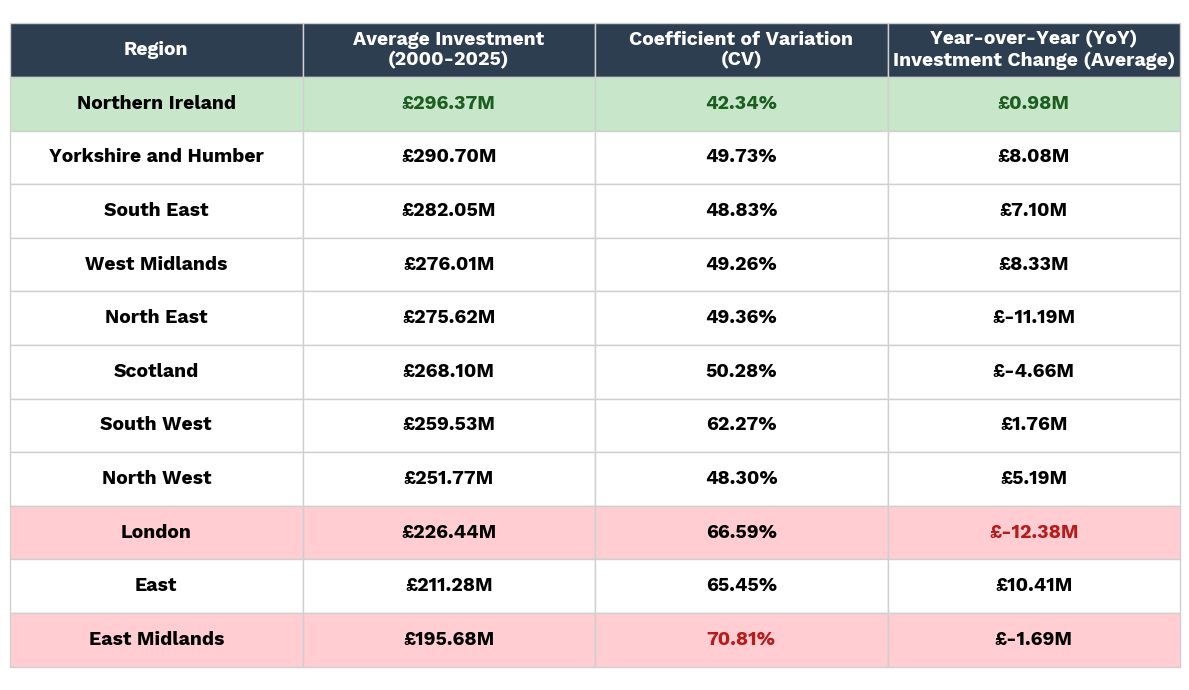


Table created using font: Work Sans
Note: If Work Sans is not installed, the system default sans-serif font will be used.


In [51]:
### Graphs and Tables

# Combine data from different analyses
# 1. Get average investment per region
avg_investment = data.groupby('region')['total_investment'].mean().reset_index()
avg_investment.columns = ['Region', 'Avg Investment']

# 2. Get CV per region
cv_data = calculate_coefficient_of_variation(data, sort_by_cv=False)
cv_data = cv_data.reset_index()
cv_data = cv_data[['Region', 'CV']].copy()

# 3. Get YoY average change per region
# Define custom region order first (same as used later)
custom_region_order = [
    'Northern Ireland',
    'Yorkshire and Humber',
    'South East',
    'West Midlands',
    'North East',
    'Scotland',
    'South West',
    'North West',
    'London',
    'East',
    'East Midlands'
]

yoy_data = calculate_average_annual_increase(data, return_format='absolute', region_order=custom_region_order)
yoy_data = yoy_data[['Region', 'Avg Absolute Increase']].copy()

# 4. Merge all data
summary_table = avg_investment.merge(cv_data[['Region', 'CV']], on='Region', how='left')
summary_table = summary_table.merge(yoy_data[['Region', 'Avg Absolute Increase']], on='Region', how='left')

# Reorder according to custom order (already defined above)
region_order_dict = {region: idx for idx, region in enumerate(custom_region_order)}
summary_table['_order'] = summary_table['Region'].map(lambda x: region_order_dict.get(x, len(custom_region_order)))
summary_table = summary_table.sort_values('_order').drop('_order', axis=1).reset_index(drop=True)

# Create beautiful table with matplotlib
from matplotlib import font_manager
import matplotlib.patches as mpatches

# Try to use Work Sans font, fallback to default if not available
try:
    # Check if Work Sans is available
    work_sans_fonts = [f.name for f in font_manager.fontManager.ttflist if 'work' in f.name.lower() and 'sans' in f.name.lower()]
    if work_sans_fonts:
        font_name = work_sans_fonts[0]
    else:
        # Try to use system font or download
        font_name = 'Work Sans'
except:
    font_name = 'sans-serif'

# Set up the figure (more concise)
fig, ax = plt.subplots(figsize=(12, 7))
ax.axis('tight')
ax.axis('off')

# Set font to Work Sans if available
try:
    title.set_fontfamily(font_name)
except:
    pass

# Prepare table data
table_data = []
for idx, row in summary_table.iterrows():
    region = row['Region']
    avg_inv = row['Avg Investment']
    cv = row['CV']
    yoy = row['Avg Absolute Increase']
    
    # Format average investment
    avg_inv_formatted = f"£{avg_inv/1e6:.2f}M"
    
    # Extract only percentage from CV (format is "0.4234 (42.34%)")
    # Extract the percentage part using regex or string manipulation
    import re
    cv_match = re.search(r'\(([\d.]+)%\)', str(cv))
    if cv_match:
        cv_percentage = f"{cv_match.group(1)}%"
    else:
        cv_percentage = cv  # Fallback if format is different
    
    table_data.append([region, avg_inv_formatted, cv_percentage, yoy])

# Column headers
columns = ['Region', 'Average Investment\n(2000-2025)', 'Coefficient of Variation\n(CV)', 
           'Year-over-Year (YoY)\nInvestment Change (Average)']

# Create table (center alignment for better readability)
table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(13)  # Larger base font size

# Apply Work Sans font and styling
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold', fontsize=14)
        cell.set_facecolor('#2C3E50')
        cell.set_text_props(color='white')
    else:
        # Larger font size for numbers/data
        cell.set_text_props(fontsize=14)
        cell.set_facecolor('#FFFFFF')
        cell.set_text_props(color='black')
    
    # Set font to Work Sans if available
    try:
        cell.get_text().set_fontfamily(font_name)
    except:
        pass
    
    # More concise cell height
    cell.set_height(0.08)
    cell.set_edgecolor('#D0D0D0')
    cell.set_linewidth(1)

# Apply conditional formatting (darker colors)
for i in range(1, len(table_data) + 1):
    region = table_data[i-1][0]
    yoy_value = table_data[i-1][3]
    
    # Northern Ireland - darker green background, bold green text for numbers only
    if region == 'Northern Ireland':
        for j in range(4):
            table[(i, j)].set_facecolor('#C8E6C9')  # Darker green background
        # Apply bold green only to numeric columns (skip column 0 which is the region name)
        for j in range(1, 4):  # Columns 1, 2, 3 (the numbers)
            table[(i, j)].get_text().set_color('#1B5E20')  # Darker green text
            table[(i, j)].get_text().set_weight('bold')  # Bold
    
    # London and East Midlands - darker red
    elif region in ['London', 'East Midlands']:
        for j in range(4):
            table[(i, j)].set_facecolor('#FFCDD2')  # Darker red background
        
        # Highlight specific values in darker red
        if region == 'London':
            # Highlight YoY value in darker red
            table[(i, 3)].get_text().set_color('#B71C1C')  # Darker red
        elif region == 'East Midlands':
            # Highlight CV value in darker red
            table[(i, 2)].get_text().set_color('#B71C1C')  # Darker red

plt.tight_layout()

# Save table in high resolution
plt.savefig('investment_analysis_table.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
print("✓ Table saved as 'investment_analysis_table.png' (300 DPI)")

plt.show()

print(f"\nTable created using font: {font_name}")
print("Note: If Work Sans is not installed, the system default sans-serif font will be used.")

In [14]:
### CRITICAL YEARS ANALYSIS

# 1. Compute volatility (std dev) across regions for each year
yearly_volatility = (
    data.groupby("year")["total_investment"]
        .std()
        .reset_index()
        .rename(columns={"total_investment": "yearly_std"})
)

# Sort by highest instability
critical_years = yearly_volatility.sort_values("yearly_std", ascending=False)

print("Top critical years by investment volatility:")

# format std as ~£193M
def fmt(x):
    return f"~£{x/1e6:.0f}M"

critical_years['Formatted Std'] = critical_years['yearly_std'].apply(fmt)

critical_years

## comments

## In 2016, investments across regions deviated on average by ~£193M from the UK-wide mean investment of that year.

## The years before and after Braxit are the most volatile years (2016 and 2018). Brexit might have been more disruptive to the private sector then the pandemic.
## The years after and before the pandemic are also in the top 10 most volatile years (2019, 2022, 2023, 2024)
## 2021 is not in the top 10, which is interesting: low activity evenly spread across the country? 
## Low volatility but high uncertainty. Private investment goes silent. 

Top critical years by investment volatility:


,year,yearly_std,Formatted Std
16,2016,"193,522,580.19",~£194M
18,2018,"175,767,248.78",~£176M
23,2023,"171,402,153.59",~£171M
22,2022,"159,627,180.11",~£160M
5,2005,"158,133,079.66",~£158M
19,2019,"157,764,118.45",~£158M
24,2024,"154,716,256.34",~£155M
20,2020,"149,467,037.96",~£149M
10,2010,"148,291,415.87",~£148M
11,2011,"147,473,367.52",~£147M


In [15]:
## Let's cross the information: investment volatility across years and regions.
## Question: “In the most unstable years (top 10 critical years), how did each region behave on average? Did they tend to gain, lose, or swing wildly?” 

# ----------------------------

# Select Top N critical years (here N=10)

critical_years = yearly_volatility.sort_values("yearly_std", ascending=False).head(10)
critical_list = critical_years["year"].tolist()

print("Critical Years Identified:", critical_list)


# 2. Compute YoY per region

data = data.sort_values(["region", "year"]).copy()

data["yoy_abs"] = data.groupby("region")["total_investment"].diff()
data["yoy_pct"] = data.groupby("region")["total_investment"].pct_change() * 100


# 3. Filter data to critical years

critical_df = data[data["year"].isin(critical_list)]


# 4. Compute mean YoY_abs and YoY_pct per region for the critical years

impact_by_region = (
    critical_df.groupby("region")[["yoy_abs", "yoy_pct"]]
    .mean()
    .reset_index()
)

# Sort by yoy_abs from lowest to highest (before formatting)
impact_by_region = impact_by_region.sort_values("yoy_abs", ascending=True).reset_index(drop=True)

# Format values for readability
impact_by_region["yoy_abs"] = impact_by_region["yoy_abs"].apply(lambda x: f"£{x/1e6:.2f}M")
impact_by_region["yoy_pct"] = impact_by_region["yoy_pct"].apply(lambda x: f"{x:.2f}%")


# 5. Display formatted table
## This table is answering: “During the years where the UK investment system experienced the highest volatility, how did each region perform on average?”

print("\nImpact of Critical Years on Each Region:")
display(impact_by_region)


# 6. Display critical years with formatted std values

critical_years["Formatted Std"] = critical_years["yearly_std"].apply(lambda x: f"~£{x/1e6:.0f}M")

print("\nTop 10 Critical Years by Volatility:")
display(critical_years[["year", "Formatted Std"]])

Critical Years Identified: [2016, 2018, 2023, 2022, 2005, 2019, 2024, 2020, 2010, 2011]

Impact of Critical Years on Each Region:


,region,yoy_abs,yoy_pct
0,South East,£-102.40M,-11.28%
1,North West,£-86.99M,-16.23%
2,Yorkshire and Humber,£-70.13M,-5.03%
3,London,£-68.01M,115.62%
4,East,£-65.50M,30.94%
5,East Midlands,£10.34M,220.89%
6,West Midlands,£15.11M,119.17%
7,Scotland,£15.20M,21.79%
8,North East,£16.46M,483.43%
9,Northern Ireland,£50.09M,121.09%



Top 10 Critical Years by Volatility:


,year,Formatted Std
16,2016,~£194M
18,2018,~£176M
23,2023,~£171M
22,2022,~£160M
5,2005,~£158M
19,2019,~£158M
24,2024,~£155M
20,2020,~£149M
10,2010,~£148M
11,2011,~£147M


✓ Table saved as 'critical_years.png' (300 DPI)


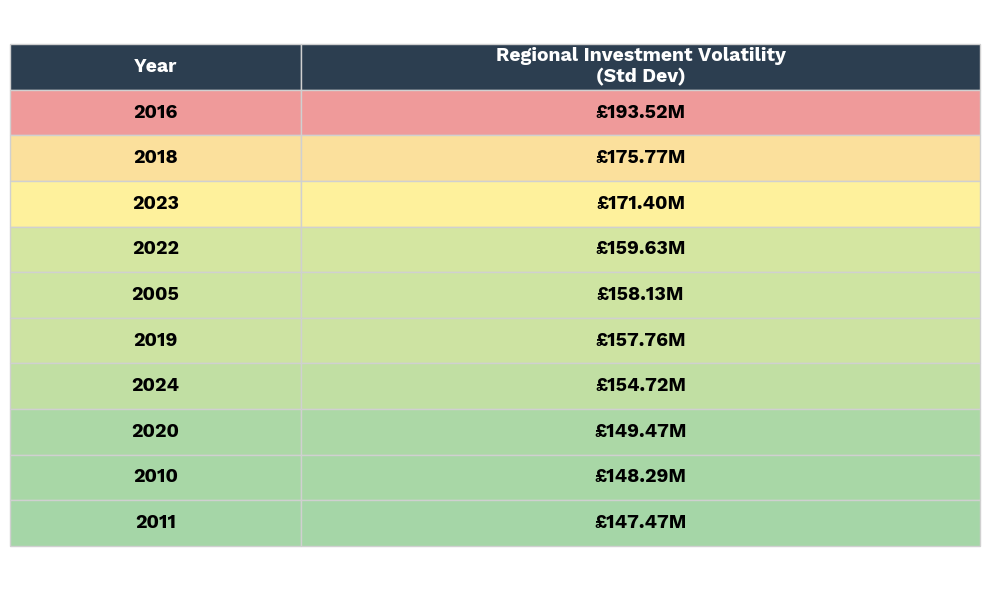


Table created using font: Work Sans
Gradient: High volatility (darker red) → Medium (saturated yellow) → Low volatility (darker green)


In [50]:
## Top 10 Critical Years by Volatility - Styled Table with Gradient

# Get top 10 critical years
top_10_critical = yearly_volatility.sort_values("yearly_std", ascending=False).head(10).copy()

# Format the volatility values
top_10_critical['Formatted Volatility'] = top_10_critical['yearly_std'].apply(
    lambda x: f"£{x/1e6:.2f}M"
)

# Prepare data for table
table_data = []
for idx, row in top_10_critical.iterrows():
    year = int(row['year'])
    volatility = row['Formatted Volatility']
    table_data.append([year, volatility])

# Column headers (more concise)
columns = ['Year', 'Regional Investment Volatility\n(Std Dev)']


# Try to use Work Sans font
try:
    from matplotlib import font_manager
    work_sans_fonts = [f.name for f in font_manager.fontManager.ttflist if 'work' in f.name.lower() and 'sans' in f.name.lower()]
    if work_sans_fonts:
        font_name = work_sans_fonts[0]
    else:
        font_name = 'Work Sans'
except:
    font_name = 'sans-serif'

# Set up the figure (more concise)
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table (center alignment for better readability)
table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center',
                colWidths=[0.3, 0.7])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(13)  # Larger base font size

# Get min and max volatility for gradient calculation
min_volatility = top_10_critical['yearly_std'].min()
max_volatility = top_10_critical['yearly_std'].max()
volatility_range = max_volatility - min_volatility

# Function to calculate gradient color with smooth interpolation (darker colors)
def get_gradient_color(value, min_val, max_val, range_val):
    """
    Returns a color based on smooth gradient with darker, more saturated colors:
    - High volatility (max): Darker red (#FFCDD2 or #EF9A9A)
    - Low volatility (min): Darker green (#C8E6C9 or #A5D6A7)
    - Medium: More saturated yellow (#FFF59D or #FFEB3B)
    
    Uses smooth interpolation between colors for better visual gradient.
    """
    if range_val == 0:
        return '#FFF59D'  # Default to yellowish if no range
    
    # Normalize value between 0 and 1
    normalized = (value - min_val) / range_val
    
    # Define darker color stops
    # Green (low volatility): RGB(165, 214, 167) = #A5D6A7 (darker green)
    # Yellow (medium): RGB(255, 245, 157) = #FFF59D (more saturated yellow)
    # Red (high volatility): RGB(239, 154, 154) = #EF9A9A (darker red)
    
    # Interpolate between colors based on normalized value
    if normalized <= 0.5:
        # Interpolate between green and yellow (0 to 0.5)
        t = normalized * 2  # Scale to 0-1 for this segment
        # Green to Yellow
        r = int(165 + (255 - 165) * t)
        g = int(214 + (245 - 214) * t)
        b = int(167 + (157 - 167) * t)
    else:
        # Interpolate between yellow and red (0.5 to 1.0)
        t = (normalized - 0.5) * 2  # Scale to 0-1 for this segment
        # Yellow to Red
        r = int(255 + (239 - 255) * t)
        g = int(245 + (154 - 245) * t)
        b = int(157 + (154 - 157) * t)
    
    return f'#{r:02X}{g:02X}{b:02X}'

# Apply Work Sans font and styling with gradient
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold', fontsize=14)
        cell.set_facecolor('#2C3E50')
        cell.set_text_props(color='white')
    else:
        # Larger font size for numbers/data
        cell.set_text_props(fontsize=14)
        cell.set_text_props(color='black')
        
        # Apply gradient to entire row based on volatility
        volatility_value = top_10_critical.iloc[i-1]['yearly_std']
        gradient_color = get_gradient_color(volatility_value, min_volatility, max_volatility, volatility_range)
        cell.set_facecolor(gradient_color)
    
    # Set font to Work Sans if available
    try:
        cell.get_text().set_fontfamily(font_name)
    except:
        pass
    
    # More concise cell height
    cell.set_height(0.08)
    cell.set_edgecolor('#D0D0D0')
    cell.set_linewidth(1)

plt.tight_layout()

# Save table in high resolution
plt.savefig('critical_years.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
print("✓ Table saved as 'critical_years.png' (300 DPI)")

plt.show()

print(f"\nTable created using font: {font_name}")
print("Gradient: High volatility (darker red) → Medium (saturated yellow) → Low volatility (darker green)")


✓ Table saved as 'impact_critical_years_table.png' (300 DPI)


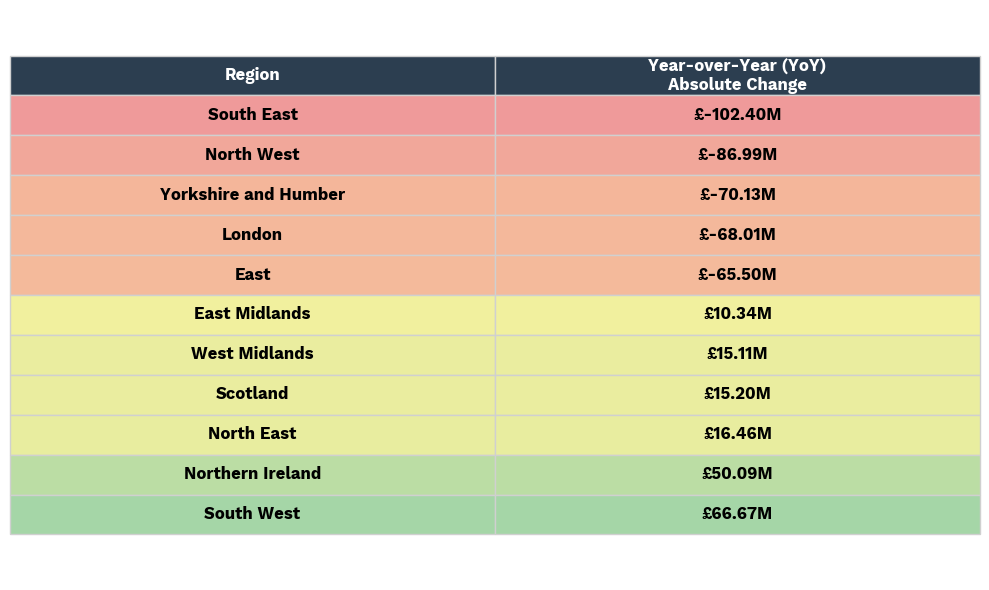


Table created using font: Work Sans
Gradient: Negative YoY (darker red) → Near Zero (yellow) → Positive YoY (darker green)


In [29]:
## Impact of Critical Years on Each Region - Styled Table with Gradient

# Recalculate impact data to get numeric values for gradient (before formatting)
# This uses the same logic as cell 9 but keeps numeric values

# Get critical years list
critical_years_list = yearly_volatility.sort_values("yearly_std", ascending=False).head(10)["year"].tolist()

# Compute YoY per region
data_sorted = data.sort_values(["region", "year"]).copy()
data_sorted["yoy_abs"] = data_sorted.groupby("region")["total_investment"].diff()
data_sorted["yoy_pct"] = data_sorted.groupby("region")["total_investment"].pct_change() * 100

# Filter to critical years
critical_df = data_sorted[data_sorted["year"].isin(critical_years_list)]

# Compute mean YoY_abs and YoY_pct per region (keep numeric for gradient)
impact_data = (
    critical_df.groupby("region")[["yoy_abs", "yoy_pct"]]
    .mean()
    .reset_index()
)

# Sort by yoy_abs from lowest to highest
impact_data = impact_data.sort_values("yoy_abs", ascending=True).reset_index(drop=True)

# Prepare table data with formatted values
table_data = []
for idx, row in impact_data.iterrows():
    region = row['region']
    yoy_abs = row['yoy_abs']
    
    # Format values
    yoy_abs_formatted = f"£{yoy_abs/1e6:.2f}M"
    
    table_data.append([region, yoy_abs_formatted])

# Column headers
columns = ['Region', 'Year-over-Year (YoY)\nAbsolute Change']

# Try to use Work Sans font
try:
    from matplotlib import font_manager
    work_sans_fonts = [f.name for f in font_manager.fontManager.ttflist if 'work' in f.name.lower() and 'sans' in f.name.lower()]
    if work_sans_fonts:
        font_name = work_sans_fonts[0]
    else:
        font_name = 'Work Sans'
except:
    font_name = 'sans-serif'

# Set up the figure (more concise)
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table (center alignment for better readability)
table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center',
                colWidths=[0.5, 0.5])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(16)  # Bigger font size

# Get min and max yoy_abs for gradient calculation
min_yoy = impact_data['yoy_abs'].min()
max_yoy = impact_data['yoy_abs'].max()
yoy_range = max_yoy - min_yoy

# Function to calculate gradient color based on YoY absolute change
# Negative values (losses) = red, positive values (gains) = green, near zero = yellow
def get_yoy_gradient_color(value, min_val, max_val, range_val):
    """
    Returns a color based on YoY change:
    - Negative values (losses): Darker red
    - Positive values (gains): Darker green
    - Near zero: Yellowish
    """
    if range_val == 0:
        return '#FFF59D'  # Default to yellowish if no range
    
    # Normalize value between 0 and 1
    normalized = (value - min_val) / range_val
    
    # Define color stops
    # Red (negative/low): RGB(239, 154, 154) = #EF9A9A (darker red)
    # Yellow (zero/medium): RGB(255, 245, 157) = #FFF59D (saturated yellow)
    # Green (positive/high): RGB(165, 214, 167) = #A5D6A7 (darker green)
    
    # Find where zero falls in the normalized range
    zero_normalized = (0 - min_val) / range_val if range_val != 0 else 0.5
    
    if normalized <= zero_normalized:
        # Interpolate between red and yellow (negative to zero)
        if zero_normalized == 0:
            t = 1.0
        else:
            t = normalized / zero_normalized
        # Red to Yellow
        r = int(239 + (255 - 239) * t)
        g = int(154 + (245 - 154) * t)
        b = int(154 + (157 - 154) * t)
    else:
        # Interpolate between yellow and green (zero to positive)
        if zero_normalized == 1:
            t = 0.0
        else:
            t = (normalized - zero_normalized) / (1 - zero_normalized)
        # Yellow to Green
        r = int(255 + (165 - 255) * t)
        g = int(245 + (214 - 245) * t)
        b = int(157 + (167 - 157) * t)
    
    return f'#{r:02X}{g:02X}{b:02X}'

# Apply Work Sans font and styling with gradient
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold', fontsize=12)
        cell.set_facecolor('#2C3E50')
        cell.set_text_props(color='white')
    else:
        # Bigger font size for numbers/data
        cell.set_text_props(fontsize=12)
        cell.set_text_props(color='black')
        
        # Apply gradient to entire row based on YoY absolute change
        yoy_value = impact_data.iloc[i-1]['yoy_abs']
        gradient_color = get_yoy_gradient_color(yoy_value, min_yoy, max_yoy, yoy_range)
        cell.set_facecolor(gradient_color)
    
    # Set font to Work Sans if available
    try:
        cell.get_text().set_fontfamily(font_name)
    except:
        pass
    
    # More concise cell height
    cell.set_height(0.07)
    cell.set_edgecolor('#D0D0D0')
    cell.set_linewidth(1)

plt.tight_layout()

# Save table in high resolution
plt.savefig('impact_critical_years_table.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
print("✓ Table saved as 'impact_critical_years_table.png' (300 DPI)")

plt.show()

print(f"\nTable created using font: {font_name}")
print("Gradient: Negative YoY (darker red) → Near Zero (yellow) → Positive YoY (darker green)")
